## **INTRODUÇÃO**

Técnicas de regularização consistem em métodos que visam reduzir o sobreajuste (*overfitting*) em modelos de predição. Nesse sentido, a regularização compreende diversas técnicas voltadas a aumentar a capacidade de generalização do modelo, haja vista que o *overfitting* corresponde a uma adequação excessiva aos dados de treino, o que prejudica a atuação do modelo no que tange a dados novos (como os dados de teste). Dentre tais métodos destacam-se o Early stopping (faça uma "Parada Antecipada" na fera 4.2 caso queira saber mais 😉) e o Dropout - enfoque do presente notebook.

A técnica de Dropout regulariza redes neurais removendo nós da rede aleatoriamente durante o treinamento (isso inclui remover também as entradas e saídas desse nó). Nesse sentido, em cada iteração do ciclo de treinamento da rede, uma fração de seus neurônios é aleatoriamente desativada. Tal processo evita que a rede se torne muito dependente de certos neurônios, ajudando-a a aprender características mais gerais e, portanto, fazendo com que ela tenha uma melhor performance perante dados novos.

Assim, a arquitetura da rede é mantida com um tamanho fixo enquanto o dropout treina variações ao excluir nós distintos a cada iteração. Na etapa de teste, um modelo sem dropout é utilizado, pautando-se em uma média aproximada resultante das diferentes arquiteturas modificadas geradas no treinamento com dropout. Assim, o dropout é capaz de simular o treinamento de múltiplas redes neurais com distintas arquiteturas. [1,2]


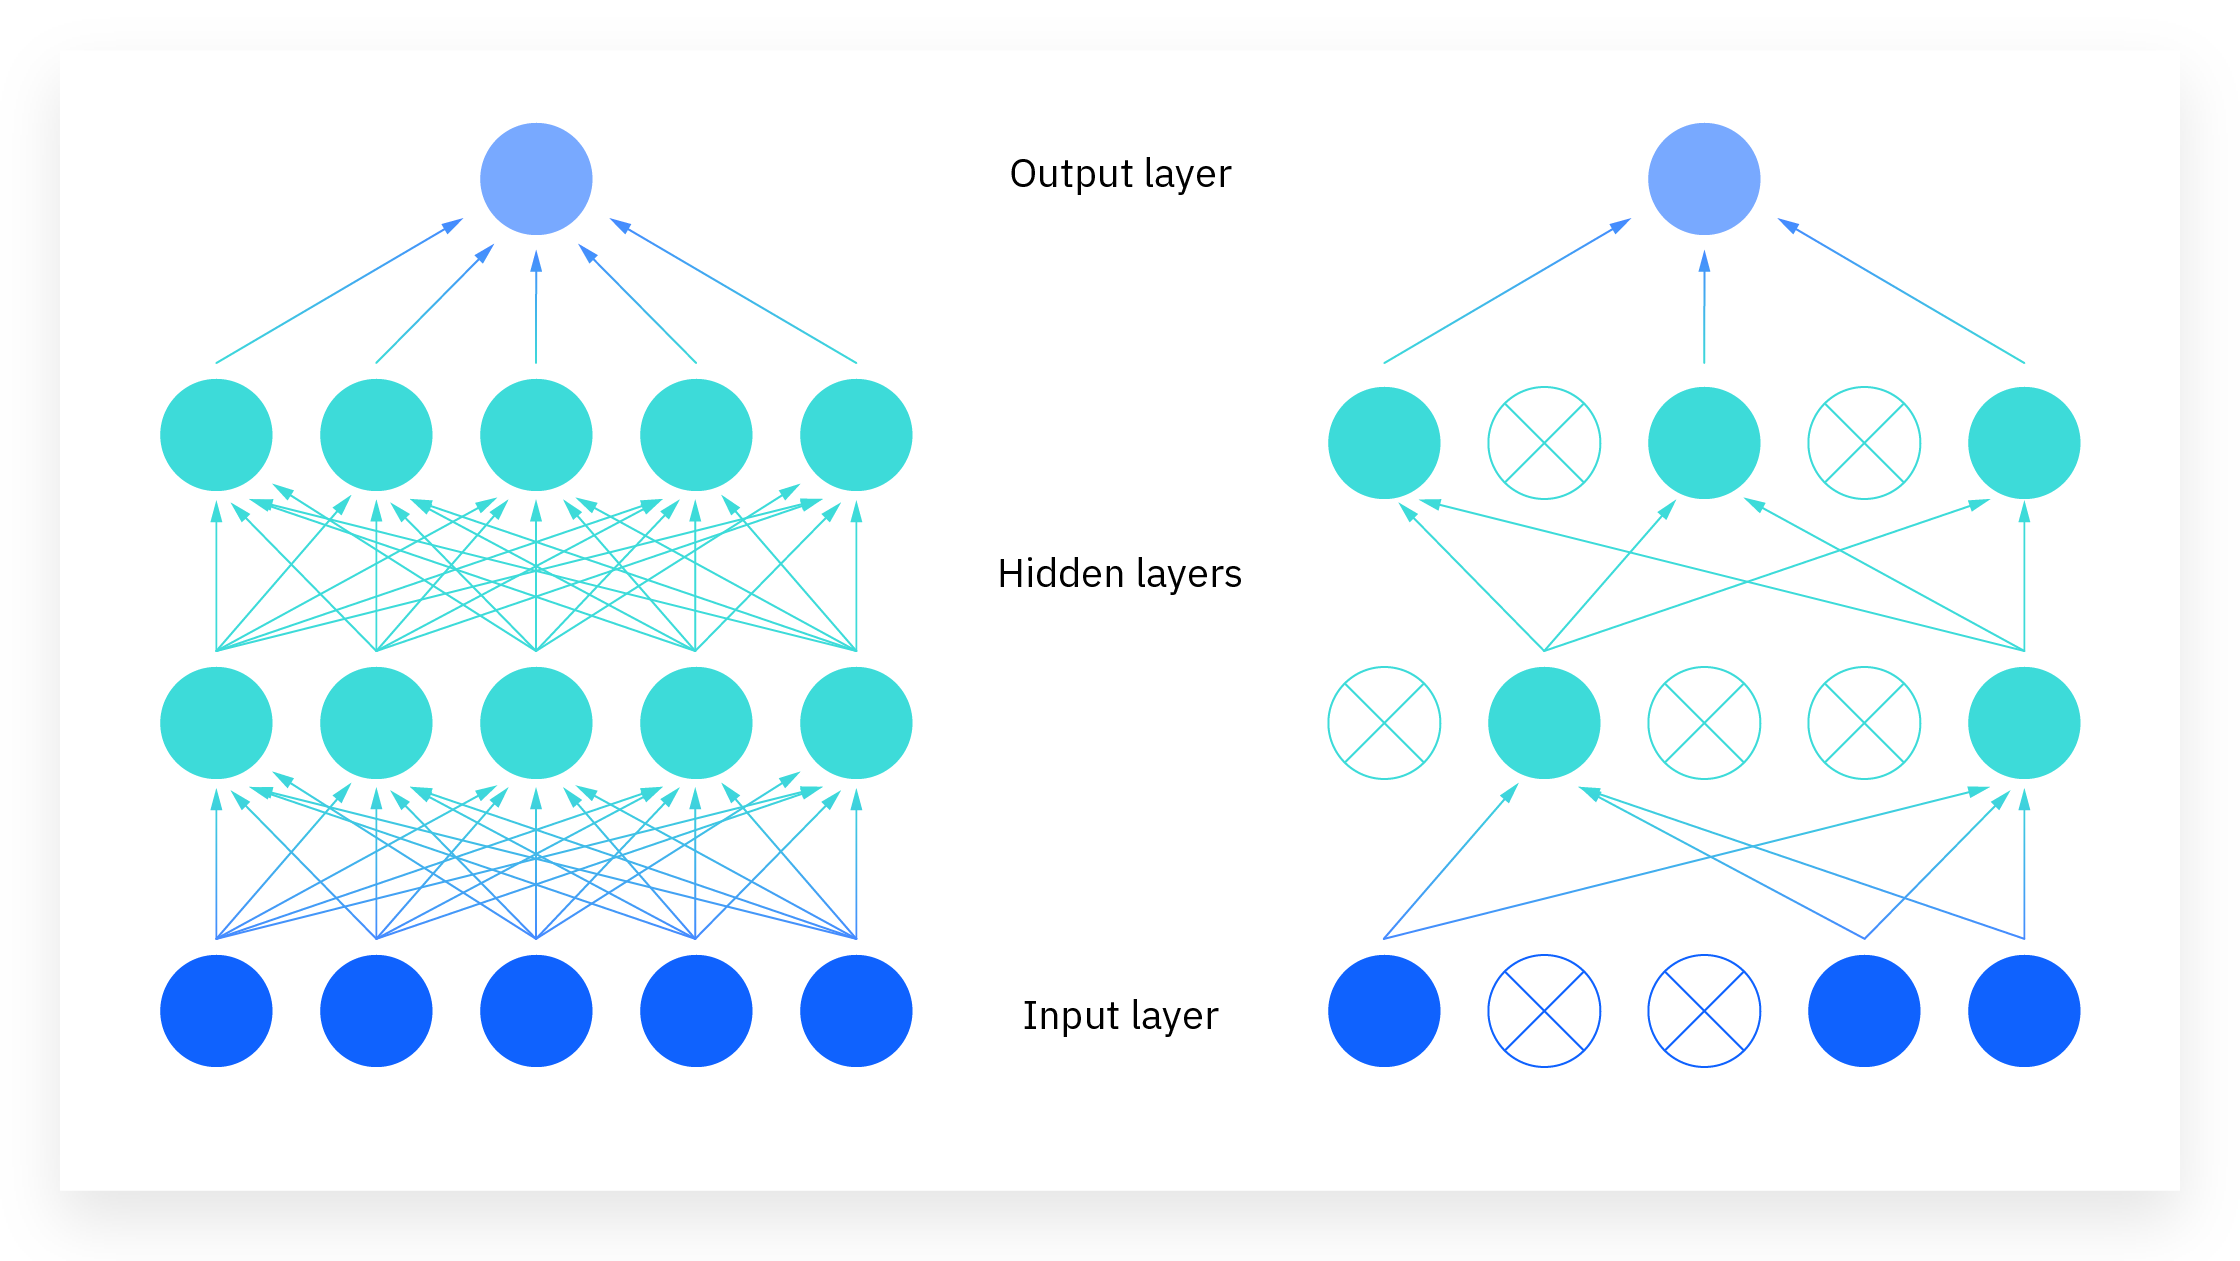

Ok, então o dropout é utilizado apenas durante o treinamento e o resultado proveniente disso aplicado no teste! Mas como isso funciona, efetivamente?

- **Etapa de treino**: A cada iteração, o dropout desativa aleatoriamente uma fração de neurônios da rede neural, criando uma rede nova e menor, com menos neurônios a cada iteração. O modelo, então, aprende a trabalhar sem depender de um nó (neurônio) específico. Isso leva à redução do sobreajuste.

- **Etapa de teste**: Todos os neurônios estão ativos (não se aplica dropout no momento da predição de novos dados), contudo, com pesos reduzidos, considerando as distintas arquiteturas da rede no treinamento, de acordo com a taxa de dropout. Isso costuma ser feito com base em um fator dado por $1 — p$, sendo $p$ a taxa de dropout, com o intuito de garantir o mesmo intervalo de saída durante o treinamento. [2]


Contudo, sendo possível evitar tal trabalho durante a etapa de inferência, podemos escalonar as ativações durante o treinamento por $\frac{1}{1 - p}$. Desse modo, os neurônios ativos (que não foram desativados) têm sua saída multiplicada por esse valor, assim, a média da saída continua igual. Essa abordagem torna desnecessário multiplicar pesos ou ativações na predição, porque o ajuste já foi realizado no treino. Tal estratégia, mais utilizada e eficiente, é a que iremos implementar! [3]



---

## **AUTORES E CONTRIBUIÇÕES**

**Autores:**

* Caio Matheus Leão Dantas
* Raquel de Godoy Vianna

**Contribuições:** A investigação do problema e o tratamento dos dados foram realizados pela Raquel, enquanto a implementação do Dropout na rede foi feita pelo Caio. Desse modo, ambos contribuíram igualmente para o desenvolvimento da tarefa. 

---

## **CÓDIGO**

Bibliotecas importadas (essas bibliotecas são da biblioteca padrão do Python, então seguimos no Python puro).

In [1]:
import random
import math
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Para a implementação da estratégia de Dropout, vamos trazer o código feito em Python puro anteriormente na disciplina e só adaptá-lo aos nossos objetivos.

In [2]:
class Valor:
    def __init__(self, data, progenitor=(), operador_mae="", rotulo=""):
        self.data = data
        self.progenitor = progenitor
        self.operador_mae = operador_mae
        self.rotulo = rotulo
        self.grad = 0

    def __repr__(self):
        return f"Valor(data={self.data})"

    def __add__(self, outro_valor):
        """Realiza a operação: self + outro_valor."""

        if not isinstance(outro_valor, Valor):
            outro_valor = Valor(outro_valor)

        progenitor = (self, outro_valor)
        data = self.data + outro_valor.data
        operador_mae = "+"
        resultado = Valor(data, progenitor, operador_mae)

        def propagar_adicao():
            self.grad += resultado.grad
            outro_valor.grad += resultado.grad

        resultado.propagar = propagar_adicao

        return resultado

    def __mul__(self, outro_valor):
        """Realiza a operação: self * outro_valor."""

        if not isinstance(outro_valor, Valor):
            outro_valor = Valor(outro_valor)

        progenitor = (self, outro_valor)
        data = self.data * outro_valor.data
        operador_mae = "*"
        resultado = Valor(data, progenitor, operador_mae)

        def propagar_multiplicacao():
            self.grad += resultado.grad * outro_valor.data # grad_filho * derivada filho em relação a mãe
            outro_valor.grad += resultado.grad * self.data

        resultado.propagar = propagar_multiplicacao

        return resultado

    def exp(self):
        """Realiza a operação: exp(self)"""
        progenitor = (self, )
        data = math.exp(self.data)
        operador_mae = "exp"
        resultado = Valor(data, progenitor, operador_mae)

        def propagar_exp():
            self.grad += resultado.grad * data

        resultado.propagar = propagar_exp

        return resultado

    def __pow__(self, expoente):
        """Realiza a operação: self ** expoente"""
        assert isinstance(expoente, (int, float))
        progenitor = (self, )
        data = self.data ** expoente
        operador_mae = f"**{expoente}"
        resultado = Valor(data, progenitor, operador_mae)

        def propagar_pow():
            self.grad += resultado.grad * (expoente * self.data ** (expoente - 1))

        resultado.propagar = propagar_pow

        return resultado

    def __truediv__(self, outro_valor):
        """Realiza a operação: self / outro_valor"""
        return self * outro_valor ** (-1)

    def __neg__(self):
        """Realiza a operação: -self"""
        return self * -1

    def __sub__(self, outro_valor):
        """Realiza a operação: self - outro_valor"""
        return self + (-outro_valor)

    def __radd__(self, outro_valor):
        """Realiza a operação: outro_valor + self"""
        return self + outro_valor

    def __rmul__(self, outro_valor):
        """Realiza a operação: outro_valor * self"""
        return self * outro_valor

    def sig(self):
        """Realiza a operação: exp(self) / (exp(self) + 1)"""
        return self.exp() / (self.exp() + 1)

    def propagar(self):
        pass

    def propagar_tudo(self):

        self.grad = 1

        ordem_topologica = []

        visitados = set()

        def constroi_ordem_topologica(v):
            if v not in visitados:
                visitados.add(v)
                for progenitor in v.progenitor:
                    constroi_ordem_topologica(progenitor)
                ordem_topologica.append(v)

        constroi_ordem_topologica(self)

        for vertice in reversed(ordem_topologica):
            vertice.propagar()

In [3]:
class Neuronio:
    def __init__(self, num_dados_entrada):
        self.vies = Valor(random.uniform(-1, 1))

        self.pesos = []
        for i in range(num_dados_entrada):
            self.pesos.append(Valor(random.uniform(-1, 1)))

    def __call__(self, x):

        assert len(x) == len(self.pesos)

        soma = 0
        for info_entrada, peso_interno in zip(x, self.pesos):
            soma += info_entrada * peso_interno

        soma += self.vies
        dado_de_saida = soma.sig()

        return dado_de_saida

    def parametros(self):
        return self.pesos + [self.vies]

Como visto acima, as classes Valor e Neurônio não vão possuir nenhuma alteração para que o dropout funcione. Entretanto, nas classes a seguir, veremos algumas mudanças para que a estratégia seja implementada.

Começando na classe Camada, é exatamente onde a estratégia de dropout em si é definida. Como falado anteriormente, o processo só pode ser realizado propriamente durante o treinamento e, com isso, precisamos ter a certeza de que estamos nessa etapa da rede e aí sim excluir (ou não) os neurônios.

In [4]:
class Camada:
    def __init__(self, num_neuronios, num_dados_entrada, prob_dropout):
        neuronios = []

        for _ in range(num_neuronios):
            neuronio = Neuronio(num_dados_entrada)
            neuronios.append(neuronio)

        self.neuronios = neuronios
        self.prob_dropout = prob_dropout ### adicionamos e instanciamos a probabilidade de dropout na Classe
        self.n_neuronios_desligados = 0

    def __call__(self, x, treinamento = True): ### lembrar sempre que o dropout só pode ser feito durante o treinamento
        dados_de_saida = []

        self.n_neuronios_desligados = 0

        for neuronio in self.neuronios:
            informacao = neuronio(x)

            # --------
            # Estratégia de Dropout
            # --------

            if treinamento == True:
              if random.random() < self.prob_dropout:
                informacao = Valor(0.0)
                self.n_neuronios_desligados += 1
              else:
                informacao = informacao * (1.0 / (1.0 - self.prob_dropout)) ### correção da média de saída da rede com dropout em função da rede sem dropout

            dados_de_saida.append(informacao)

        if len(dados_de_saida) == 1:
            return dados_de_saida[0]
        else:
            return dados_de_saida

    def parametros(self):
        params = []

        for neuronio in self.neuronios:
            params_neuronio = neuronio.parametros()
            params.extend(params_neuronio)

        return params

E além da classe Camada, na classe MLP definida abaixo, já podemos ver que os métodos recebem um argumento referido a probabilidade de ocorrer o dropout, sendo parte essencial no processo.

In [5]:
class MLP:
    def __init__(self, num_dados_entrada, num_neuronios_por_camada, prob_dropout):

        percurso = [num_dados_entrada] + num_neuronios_por_camada

        camadas = []

        for i in range(len(num_neuronios_por_camada)):
            camada = Camada(num_neuronios_por_camada[i], percurso[i], prob_dropout)
            camadas.append(camada)

        self.camadas = camadas

    def __call__(self, x, treinamento = True):
        for camada in self.camadas:
            x = camada(x, treinamento = treinamento)
        return x

    def parametros(self):
        params = []

        for camada in self.camadas:
            parametros_camada = camada.parametros()
            params.extend(parametros_camada)

        return params

Com todas as classes agora já definidas e com a estratégia de dropout inclusa, podemos fazer nosso processo de treinamento da rede por épocas a partir de uma probabilidade de dropout, contando exatamente quantos neurônios foram desligados durante esse treinamento.

In [6]:
x = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]

y_true = [1, 0, 0.2, 0.5]

NUM_DADOS_DE_ENTRADA = 3
NUM_DADOS_DE_SAIDA = 1
CAMADAS_OCULTAS = [3, 2]
PROB_DROPOUT = 0.3

arquitetura_da_rede = CAMADAS_OCULTAS + [NUM_DADOS_DE_SAIDA]

minha_mlp = MLP(NUM_DADOS_DE_ENTRADA, arquitetura_da_rede, prob_dropout=PROB_DROPOUT)

In [7]:
NUM_EPOCAS = 200
TAXA_DE_APRENDIZADO = 0.5

historico_perda = []

for epoca in range(NUM_EPOCAS):
    # forward pass
    y_pred = []
    for exemplo in x:
        previsao = minha_mlp(exemplo, treinamento = True)
        y_pred.append(previsao)

    # loss
    erros = []
    for yt, yp in zip(y_true, y_pred):
        residuo = yp - yt
        erro_quadratico = residuo ** 2
        erros.append(erro_quadratico)
    loss = sum(erros)
    historico_perda.append(loss.data)

    # zero grad
    for p in minha_mlp.parametros():
        p.grad = 0

    # backpropagation
    loss.propagar_tudo()

    # atualiza parâmetros
    for p in minha_mlp.parametros():
        p.data = p.data - p.grad * TAXA_DE_APRENDIZADO

    # calcular a quantidade de neurônios desligados
    total_desligados = 0
    for camada in minha_mlp.camadas:
        total_desligados += camada.n_neuronios_desligados

    # mostra resultado (opcional)
    print(epoca, "|", loss.data, "|" , f"Neurônios desligados: {total_desligados}")

0 | 0.6311810956867381 | Neurônios desligados: 3
1 | 0.5462351943169726 | Neurônios desligados: 0
2 | 0.27883463066586917 | Neurônios desligados: 1
3 | 1.5366543342777639 | Neurônios desligados: 1
4 | 0.692688890515691 | Neurônios desligados: 2
5 | 1.3866023377700267 | Neurônios desligados: 4
6 | 0.7300318308967796 | Neurônios desligados: 1
7 | 1.0929117228149807 | Neurônios desligados: 2
8 | 1.2263003019842447 | Neurônios desligados: 0
9 | 0.6945118905328677 | Neurônios desligados: 2
10 | 0.4802991686555215 | Neurônios desligados: 3
11 | 0.7132408923025204 | Neurônios desligados: 4
12 | 0.6541371685998548 | Neurônios desligados: 1
13 | 0.6211249486554481 | Neurônios desligados: 2
14 | 0.3442741565950367 | Neurônios desligados: 1
15 | 0.5938789409965493 | Neurônios desligados: 1
16 | 0.46560065266855827 | Neurônios desligados: 2
17 | 0.2963248063850432 | Neurônios desligados: 5
18 | 0.6036469860883047 | Neurônios desligados: 0
19 | 0.3178802473957928 | Neurônios desligados: 1
20 | 0.26

Para analisar como exatamente a perda do modelo foi variada durante as épocas, podemos plotar a curva de aprendizado do modelo:

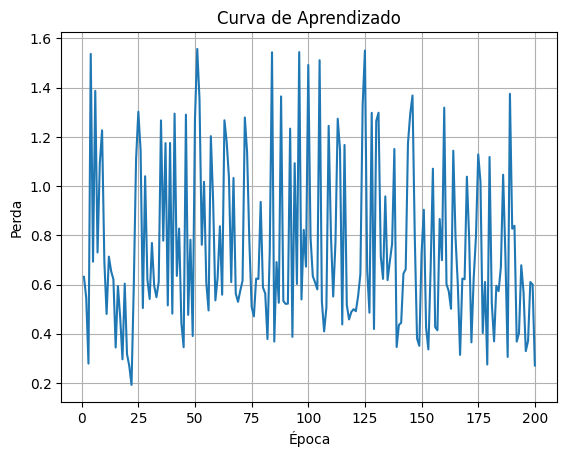

In [9]:
plt.plot(range(1, NUM_EPOCAS + 1), historico_perda)
plt.xlabel('Época')
plt.ylabel('Perda')
plt.title('Curva de Aprendizado')
plt.grid(True)
plt.show()

Maaaaaaas, nós podemos também tentar testar o que aconteceria se nós não estivessemos na etapa do treino. O que exatamente aconteceria na rede? Os neurônios seriam desligados?

Vemos abaixo:

In [10]:
x = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]

y_true = [1, 0, 0.2, 0.5]

NUM_DADOS_DE_ENTRADA = 3
NUM_DADOS_DE_SAIDA = 1
CAMADAS_OCULTAS = [3, 2]
PROB_DROPOUT = 0.3

arquitetura_da_rede = CAMADAS_OCULTAS + [NUM_DADOS_DE_SAIDA]

minha_mlp_2 = MLP(NUM_DADOS_DE_ENTRADA, arquitetura_da_rede, prob_dropout=PROB_DROPOUT)

In [11]:
NUM_EPOCAS = 200
TAXA_DE_APRENDIZADO = 0.5

historico_perda_2 = []

for epoca in range(NUM_EPOCAS):
    # forward pass
    y_pred_2 = []
    for exemplo in x:
        previsao_2 = minha_mlp_2(exemplo, treinamento = False)
        y_pred_2.append(previsao_2)

    # loss
    erros_2 = []
    for yt, yp in zip(y_true, y_pred_2):
        residuo_2 = yp - yt
        erro_quadratico_2 = residuo_2 ** 2
        erros_2.append(erro_quadratico_2)
    loss_2 = sum(erros_2)
    historico_perda_2.append(loss_2.data)

    # zero grad
    for p_2 in minha_mlp_2.parametros():
        p_2.grad = 0

    # backpropagation
    loss_2.propagar_tudo()

    # atualiza parâmetros
    for p_2 in minha_mlp_2.parametros():
        p_2.data = p_2.data - p_2.grad * TAXA_DE_APRENDIZADO

    # calcular a quantidade de neurônios desligados
    total_desligados_2 = 0
    for camada_2 in minha_mlp_2.camadas:
        total_desligados_2 += camada_2.n_neuronios_desligados

    # mostra resultado (opcional)
    print(epoca, "|", loss_2.data, "|" , f"Neurônios desligados: {total_desligados_2}")

0 | 0.5891960827124539 | Neurônios desligados: 0
1 | 0.5725022554819806 | Neurônios desligados: 0
2 | 0.5637469531301151 | Neurônios desligados: 0
3 | 0.5589731704783397 | Neurônios desligados: 0
4 | 0.5560123821330479 | Neurônios desligados: 0
5 | 0.5538241059426638 | Neurônios desligados: 0
6 | 0.551942039375388 | Neurônios desligados: 0
7 | 0.5501637247814134 | Neurônios desligados: 0
8 | 0.5484017568468053 | Neurônios desligados: 0
9 | 0.5466175125795937 | Neurônios desligados: 0
10 | 0.5447927455795362 | Neurônios desligados: 0
11 | 0.5429176698823348 | Neurônios desligados: 0
12 | 0.5409860273983216 | Neurônios desligados: 0
13 | 0.538993066199445 | Neurônios desligados: 0
14 | 0.5369347205285054 | Neurônios desligados: 0
15 | 0.5348072841095772 | Neurônios desligados: 0
16 | 0.5326072854024086 | Neurônios desligados: 0
17 | 0.5303314455656739 | Neurônios desligados: 0
18 | 0.5279766704616197 | Neurônios desligados: 0
19 | 0.5255400568279887 | Neurônios desligados: 0
20 | 0.52301

E, de novo com a curva de aprendizado, podemos analisar a variação da perda:

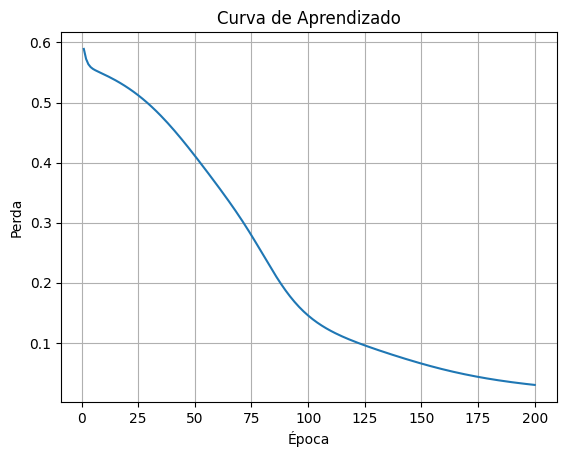

In [12]:
plt.plot(range(1, NUM_EPOCAS + 1), historico_perda_2)
plt.xlabel('Época')
plt.ylabel('Perda')
plt.title('Curva de Aprendizado')
plt.grid(True)
plt.show()

Quando não estamos na etapa de treino, o método de Dropout não é aplicado e, portanto, nenhum neurônio é desligado! Assim, a quantidade de neurônios desligados permanece sempre igual a zero. Nesse sentido, fica claro que a função de perda quando não utilizamos Dropout diminuiu muito mais rapidamente do que quando implementamos a estratégia de Dropout (durante a etapa de treino).

Embora a perda tenha sido muito menor após o treinamento da rede neural sem utilizar Dropout, devemos tomar cuidado: sem o Dropout corremos muito risco de que nossa rede neural apresente *overfitting* perante os dados que apresentamos a ela! Portanto, a melhor estratégia consiste em utilizar, durante o ciclo de treinamento, a rede neural no modo treino, implementando o Dropout.

Ok, já realizamos treinamentos com Dropout em dados sintéticos, então, e se realizarmos o treino e o teste no Dataset de pinguins da biblioteca Seaborn, visando encontrar a massa desses animais? (aproveitando que estamos mais confiantes com relação à estratégia implementada)

### **DADOS**

Importando o Dataset a ser utilizado.

In [13]:
df_penguins = pd.DataFrame(sns.load_dataset('penguins'))
df_penguins

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
...,...,...,...,...,...,...,...
339,Gentoo,Biscoe,NaN,NaN,NaN,NaN,NaN
340,Gentoo,Biscoe,46.8,14.3,215.0,4850.0,Female
341,Gentoo,Biscoe,50.4,15.7,222.0,5750.0,Male
342,Gentoo,Biscoe,45.2,14.8,212.0,5200.0,Female


Como vamos implementar uma MLP regressora, escolhemos prever a massa dos pinguins(*body_mass_g*)!


Vamos eliminar as linhas com valores faltantes (Nan):

In [14]:
df_penguins = df_penguins.dropna()
df_penguins

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,Male
...,...,...,...,...,...,...,...
338,Gentoo,Biscoe,47.2,13.7,214.0,4925.0,Female
340,Gentoo,Biscoe,46.8,14.3,215.0,4850.0,Female
341,Gentoo,Biscoe,50.4,15.7,222.0,5750.0,Male
342,Gentoo,Biscoe,45.2,14.8,212.0,5200.0,Female


Como iremos implementar uma rede neural MLP regressora, é necessário que os valores qualitativos do Dataset dos pinguins sejam convertidos para valores numéricos. Isso será feito por intermédio de um codificador ordinal:

In [15]:
#--------
#Islands
#--------

# Passo 1: transformar os dados em um array 2D
x = df_penguins['island'].values.reshape(-1, 1)

# Passo 2: criar uma instância do encoder
ordem = [["Torgersen", "Biscoe", "Dream"]] #0 - Torgersen, 1 - Biscoe, 2 - Dream
encoder = OrdinalEncoder(categories=ordem)

# Passo 3: ajustar o encoder aos dados
encoder.fit(x)

# Passo 4: aplicar o encoder usando o método `transform`
dados_convertidos = encoder.transform(x)

# Passo 5: se desejamos recuperar os valores iniciais, usamos o `inverse_transform`
#encoder.inverse_transform(dados_convertidos)

# Substituir no DataFrame:
df_penguins['island'] = dados_convertidos


#--------
#Species
#--------

# Passo 1: transformar os dados em um array 2D
x = df_penguins['species'].values.reshape(-1, 1)

# Passo 2: criar uma instância do encoder
ordem = [["Adelie", "Chinstrap", "Gentoo"]] #0 - Adelie, 1 - Chinstrap, 2 - Gentoo
encoder = OrdinalEncoder(categories=ordem)

# Passo 3: ajustar o encoder aos dados
encoder.fit(x)

# Passo 4: aplicar o encoder usando o método `transform`
dados_convertidos = encoder.transform(x)

# Passo 5: se desejamos recuperar os valores iniciais, usamos o `inverse_transform`
#encoder.inverse_transform(dados_convertidos)

# Substituir no DataFrame:
df_penguins['species'] = dados_convertidos


#--------
#Sex
#--------

# Passo 1: transformar os dados em um array 2D
x = df_penguins['sex'].values.reshape(-1, 1)

# Passo 2: criar uma instância do encoder
ordem = [["Female", "Male"]] #0 - Female, 1 - Male
encoder = OrdinalEncoder(categories=ordem)

# Passo 3: ajustar o encoder aos dados
encoder.fit(x)

# Passo 4: aplicar o encoder usando o método `transform`
dados_convertidos = encoder.transform(x)

# Passo 5: se desejamos recuperar os valores iniciais, usamos o `inverse_transform`
#encoder.inverse_transform(dados_convertidos)

# Substituir no DataFrame:
df_penguins['sex'] = dados_convertidos

<ipython-input-15-2d220604102d>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_penguins['island'] = dados_convertidos
<ipython-input-15-2d220604102d>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_penguins['species'] = dados_convertidos
<ipython-input-15-2d220604102d>:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

Dataset após as alterações realizadas:

In [16]:
df_penguins

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,0.0,0.0,39.1,18.7,181.0,3750.0,1.0
1,0.0,0.0,39.5,17.4,186.0,3800.0,0.0
2,0.0,0.0,40.3,18.0,195.0,3250.0,0.0
4,0.0,0.0,36.7,19.3,193.0,3450.0,0.0
5,0.0,0.0,39.3,20.6,190.0,3650.0,1.0
...,...,...,...,...,...,...,...
338,2.0,1.0,47.2,13.7,214.0,4925.0,0.0
340,2.0,1.0,46.8,14.3,215.0,4850.0,0.0
341,2.0,1.0,50.4,15.7,222.0,5750.0,1.0
342,2.0,1.0,45.2,14.8,212.0,5200.0,0.0


Antes de implementar o modelo preditivo, é crucial tratarmos nossos dados para que possam ser utilizados adequadamente! Assim, além de separar os dados em treino e teste, precisamos normalizá-los.


#### **Split de dados de treino e teste**


A separação dos dados em dados de treino e dados de teste serão realizados utilizando `train_test_split` da biblioteca ``sklearn``. Desse modo, definiou-se que 20% dos dados serão utilizados para o teste e os restantes - 80% - serão dados de treino do modelo.


In [17]:
semente_aleatoria = 21062016
tamanho_teste = 0.2

indices = df_penguins.index
indices_treino, indices_teste = train_test_split(
    indices, test_size=tamanho_teste, random_state=semente_aleatoria, shuffle=True
)

df_penguins_treino = df_penguins.loc[indices_treino]
df_penguins_teste = df_penguins.loc[indices_teste]

Após dividir os dados em treino e teste, vamos separar os valores que queremos prever (*target*) dos atributos (*features*) - valores que serão utilizados para tal previsão:

In [18]:
features = list(df_penguins.columns)[:5] + [list(df_penguins.columns)[-1]]
target = [list(df_penguins.columns)[-2]]

In [19]:
features

['species',
 'island',
 'bill_length_mm',
 'bill_depth_mm',
 'flipper_length_mm',
 'sex']

In [20]:
target

['body_mass_g']

*Dados de Treino*

In [21]:
df_treino_target = df_penguins_treino.reindex(target, axis=1)
df_treino_features = df_penguins_treino.reindex(features, axis=1)

*Dados de Teste*

In [22]:
df_teste_target = df_penguins_teste.reindex(target, axis=1)
df_teste_features = df_penguins_teste.reindex(features, axis=1)

Definindo arrays que representam os dados de teste e os de treino:

In [23]:
X_treino = df_treino_features.values
y_treino = df_treino_target.values.ravel()

X_teste = df_teste_features.values
y_teste = df_teste_target.values.ravel()

Realizando a normalização dos dados:

(*Observação*: Vale ressaltar que optamos por utilizar o normalizador MinMaxScaler do sklearn, pois, como utilizamos a sigmoide como função de ativação, é mais interessante para nós que nossos dados se encontrem em uma escala de 0 a 1)

In [24]:
#normalizando os valores de X:
scaler = MinMaxScaler()
scaler.fit(X_treino)              #Realiza o fit no X_treino

X_treino = scaler.transform(X_treino)
X_teste  = scaler.transform(X_teste)

In [25]:
#os dados precisam ser arrays de 2D:
y_treino = y_treino.reshape(-1, 1)
y_teste = y_teste.reshape(-1, 1)

#normalizando os valores de y:
scaler = MinMaxScaler()
scaler.fit(y_treino)  #fit no y_treino

y_treino = scaler.transform(y_treino)
y_teste  = scaler.transform(y_teste)

## **CONFERIR!!!!**: conversei com o Cassar e ele disse algo sobre normalizar os valores de y também! (Só para eu lembrar de conferir certinho como fazer isso - e onde tirar a normalização do y também para que possamos comparar mais facilmente os valores obtidos após a predição!!)

Ufa! Com o fim do tratamento dos dados a serem utilizados, resta somente treinar e implementar nosso modelo!!

#### *Treinamento*

O primeiro passo consiste em definir a arquitetura de nossa rede neural:

In [26]:
NUM_DADOS_DE_ENTRADA = len(features)  #número de atributos
NUM_DADOS_DE_SAIDA = 1
CAMADAS_OCULTAS = [3, 2]
PROB_DROPOUT = 0.2

arquitetura_da_rede = CAMADAS_OCULTAS + [NUM_DADOS_DE_SAIDA]

minha_mlp_3 = MLP(NUM_DADOS_DE_ENTRADA, arquitetura_da_rede, prob_dropout=PROB_DROPOUT)

Agora, podemos implementar o ciclo de treinamento da nossa rede neural (com Dropout):

In [27]:
NUM_EPOCAS = 200
TAXA_DE_APRENDIZADO = 0.3

historico_perda_3 = []

for epoca in range(NUM_EPOCAS):
    # forward pass
    y_pred_3 = []
    for exemplo in X_treino:
        previsao_3 = minha_mlp_3(exemplo, treinamento = True)
        y_pred_3.append(previsao_3)

    # loss
    erros_3 = []
    for yt, yp in zip(y_treino, y_pred_3):
        residuo_3 = yp - yt
        erro_quadratico_3 = residuo_3 ** 2
        erros_3.append(erro_quadratico_3)
    loss_3 = sum(erros_3)
    historico_perda_3.append(loss_3.data)

    # zero grad
    for p_3 in minha_mlp_3.parametros():
        p_3.grad = 0

    # backpropagation
    loss_3.propagar_tudo()

    # atualiza parâmetros
    for p_3 in minha_mlp_3.parametros():
        p_3.data = p_3.data - p_3.grad * TAXA_DE_APRENDIZADO

    # calcular a quantidade de neurônios desligados
    total_desligados_3 = 0
    for camada_3 in minha_mlp_3.camadas:
        total_desligados_3 += camada_3.n_neuronios_desligados

    # mostra resultado (opcional)
    print(epoca, "|", loss_3.data, "|" , f"Neurônios desligados: {total_desligados_3}")

0 | [24.17538038] | Neurônios desligados: 1


<ipython-input-2-8e31417c1829>:53: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  data = math.exp(self.data)


1 | [58.16801323] | Neurônios desligados: 1
2 | [57.91628587] | Neurônios desligados: 0
3 | [56.99409759] | Neurônios desligados: 0
4 | [55.29843906] | Neurônios desligados: 2
5 | [46.31827865] | Neurônios desligados: 1
6 | [80.71354988] | Neurônios desligados: 1
7 | [59.09987592] | Neurônios desligados: 0
8 | [59.09987617] | Neurônios desligados: 2
9 | [59.09987859] | Neurônios desligados: 0
10 | [59.09988004] | Neurônios desligados: 1
11 | [59.0998769] | Neurônios desligados: 1
12 | [59.09986534] | Neurônios desligados: 1
13 | [59.09987853] | Neurônios desligados: 2
14 | [59.09988096] | Neurônios desligados: 2
15 | [59.09988069] | Neurônios desligados: 0
16 | [59.09988208] | Neurônios desligados: 0
17 | [59.09987633] | Neurônios desligados: 3
18 | [59.09988219] | Neurônios desligados: 2
19 | [59.09986257] | Neurônios desligados: 1
20 | [59.09988207] | Neurônios desligados: 1
21 | [59.09987957] | Neurônios desligados: 2
22 | [59.09988186] | Neurônios desligados: 2
23 | [59.0998659] | 

Aqui, podemos analisar que há uma grande variação na perda, então plotaremos novamente a curva de aprendizado para entender a tendência da perda da rede em função das épocas:

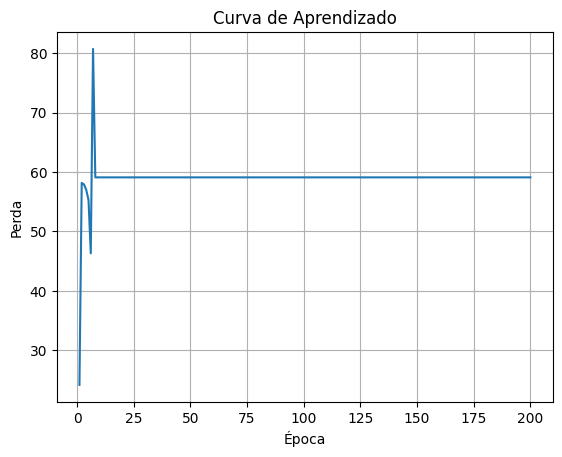

In [28]:
plt.plot(range(1, NUM_EPOCAS + 1), historico_perda_3)
plt.xlabel('Época')
plt.ylabel('Perda')
plt.title('Curva de Aprendizado')
plt.grid(True)
plt.show()

#### *Predição*

Finalmente podemos realizar a implementação de nosso modelo em dados de teste, utilizando a rede neural treinada a priori:

In [29]:
y_preditos = []
for exemplo in X_teste:
    previsao = minha_mlp_3(exemplo, treinamento = False)
    if isinstance(previsao, list):
        y_preditos.extend([p.data for p in previsao])
    else:
        y_preditos.append(previsao.data)

print("Valores de y preditos:")
print(y_preditos)
print('-----------------------------')
print(y_teste)

Valores de y preditos:
[1.0816908516149826e-07, 1.126679321642345e-07, 1.1166401417102981e-07, 1.2849967200571487e-07, 1.1072843442065595e-07, 1.2315600581664976e-07, 1.1897759586931641e-07, 1.1010902881456331e-07, 1.2005816344532015e-07, 1.1874922594785911e-07, 1.2491751406150268e-07, 1.2065998642231636e-07, 1.2284148521119937e-07, 1.2919164996149768e-07, 1.145108802994759e-07, 1.1164859329254119e-07, 1.2043695965158636e-07, 1.2076184023933187e-07, 1.1123389782072229e-07, 1.198008412175264e-07, 1.200174871858521e-07, 1.2229911572782317e-07, 1.230497357299734e-07, 1.0994510288748877e-07, 1.247787202664488e-07, 1.1232180692264654e-07, 1.2883229967106916e-07, 1.0945598203543742e-07, 1.221188557140272e-07, 1.1007145895966697e-07, 1.2509666568970865e-07, 1.2905496891113032e-07, 1.1997339489873196e-07, 1.1974945283169953e-07, 1.1154505924399115e-07, 1.2351443465625242e-07, 1.2055942605049375e-07, 1.1927040909937415e-07, 1.1960759751772008e-07, 1.2013169262282272e-07, 1.1098040108123649e-07,

<ipython-input-2-8e31417c1829>:53: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  data = math.exp(self.data)


E para ter uma noção do desempenho do modelo, utilizamos a métrica do MSE (Mean Squared Error) dos valores reais e preditos:

In [30]:
array_y_preditos = np.array(y_preditos).reshape(-1, 1)
mse = mean_squared_error(y_teste, array_y_preditos)
print(f"Mean Squared Error (MSE): {mse}")

Mean Squared Error (MSE): 0.2368264719767495


Foi possível perceber que, quando aplicada a essa arquitetura e dados utilizados, a perda varia de forma bem instável durante as épocas e não é possível ver um aprendizado claro. Tal observação fica óbvia ao passo que, nas curvas de aprendizado apresentadas, podem ser analisadas variações drásticas dos valores de perda em épocas muito próximas, gerando picos inesperados. Para além disso, os resultados obtidos demonstram. Tudo isso implica que realizamos o Dropout de maneira incorreta! O problema é que, aparentemente, não estamos atualizando os neurônios a serem desligados a cada época do treinamento, mas sim a cada camada treinada!

---

## **CONCLUSÃO**

Ainda que tenhamos obtidos resultados insatisfatórios, a partir do desenvolvimento dessa atividade, foi possível compreender melhor acerca do funcionamento da estratégia de dropout e aplicá-la na rede anteriormente feita em Python Puro. A conclusão obtida a partir das experimentações realizadas é que a estratégia de dropout pode ser de enorme importância em uma diversidade de modelos, mas no caso da rede neural e dados escolhidos, o desempenho não foi tão eficiente, haja vista a implementação inadequada desse regularizador.

---

## **REFERÊNCIAS**

Além do notebook fornecido pelo professor Daniel Roberto Cassar, abordando a implementação de uma rede neural MLP em Python puro, o seguinte material foi consultado para a elaboração do presente notebook:

**[1]** O que é Regularização? | IBM. 16 de novembro de 2023, https://www.ibm.com/br-pt/think/topics/regularization.

**[2]** Kashyap, Piyush. «Understanding Dropout in Deep Learning: A Guide to Reducing Overfitting». Medium, 30 de outubro de 2024, https://medium.com/@piyushkashyap045/understanding-dropout-in-deep-learning-a-guide-to-reducing-overfitting-26cbb68d5575.

**[3]** Mao, Lei. «Dropout Explained». Lei Mao’s Log Book, 4 de junho de 2019, https://leimao.github.io/blog/Dropout-Explained/.

**[4]** YADAV, Harsh. Dropout in Neural Networks. Towards Data Science. 2022. Disponível em: https://towardsdatascience.com/dropout-in-neural-networks-47a162d621d9/.

**[5]** SRIVASTAVA, Nitish; HINTON, Geoffrey; KRIZHEVSKY, Alex; SUTSKEVER, Ilya; SALAKHUTDINOV, Ruslan. Dropout: a simple way to prevent neural networks from overfitting. Journal of Machine Learning Research. 2014. Disponível em: https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf.